In [17]:
## source: Qutiles-3head.ipynb from pytorch-temph

Calculate metrics: \
PICP: Prediction Interval Coverage Percent \
PINAW: Predictipon Interval Ner \
https://github.com/scikit-learn/scikit-learn/issues/20162 \
Expected calibration error 

Get heatmap \
Ordinal Regression (Classes with relative distances) \
Regression via Classification \
Get concrete results (or real data) 

calibration bandı ekle \
post hoc gaussian filter \

tempeature ile çıktıyı regulerize et \
trainingdeki labelları gaussianla smoothlaştır \



Long term goal: \
Get regions as predicted set (Segmentation-YOLO) 


In [18]:
def get_cuda_summary(memory=False):
    import torch

    if torch.cuda.is_available():
        print('CUDA device = ', torch.cuda.get_device_name())
        print('Available number of devices = ', torch.cuda.device_count())
        print('Device numbers              = ', list(range(torch.cuda.device_count())))
        print('Current device              = ', torch.cuda.current_device())
        if memory:
            print(torch.cuda.memory_summary())
    else:
        print('cuda is not available')

In [19]:
import torch
get_cuda_summary()
device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.set_device(0) if torch.cuda.is_available() else None
#do not execute this if you fit auto-pytorch model

CUDA device =  NVIDIA GeForce GTX 1080 Ti
Available number of devices =  4
Device numbers              =  [0, 1, 2, 3]
Current device              =  0


In [20]:
import numpy as np
np.random.seed(42)

N = 10000
train_x = np.random.normal(0,1,(N,))
x = 3*train_x+1 # N(1,9)

# Cauchy distributed error
s = np.random.standard_cauchy(N)/2

# Laplace distribution
s = np.random.laplace(size=N)

# t-distribution
s = np.random.standard_t(df = 3, size=N)

# Normal distribution
s = np.random.normal(0, 1, N)


#xmean = np.mean(x)
#xsd = np.std(x)

# y = train_x/3*s*4 + np.sin(train_x/3*13)*4 + 10

y1 = train_x/3*s*4 + np.sin(train_x/3*13)*4 + 10
x1 = train_x
y2 = train_x/3*s*4 + np.sin(train_x/3*13)*4 + 20
x2 = train_x

# y = np.concatenate((y1, y2))
# x = np.concatenate((x1, x2))
# train_x = np.concatenate((x1, x2))

y = y1
x = x1
train_x = x1

ymean = np.mean(y)
ysd = np.std(y)

xmean = np.mean(x)
xsd = np.std(x)
train_y = (y-ymean)/ysd

In [21]:
y.shape

(10000,)

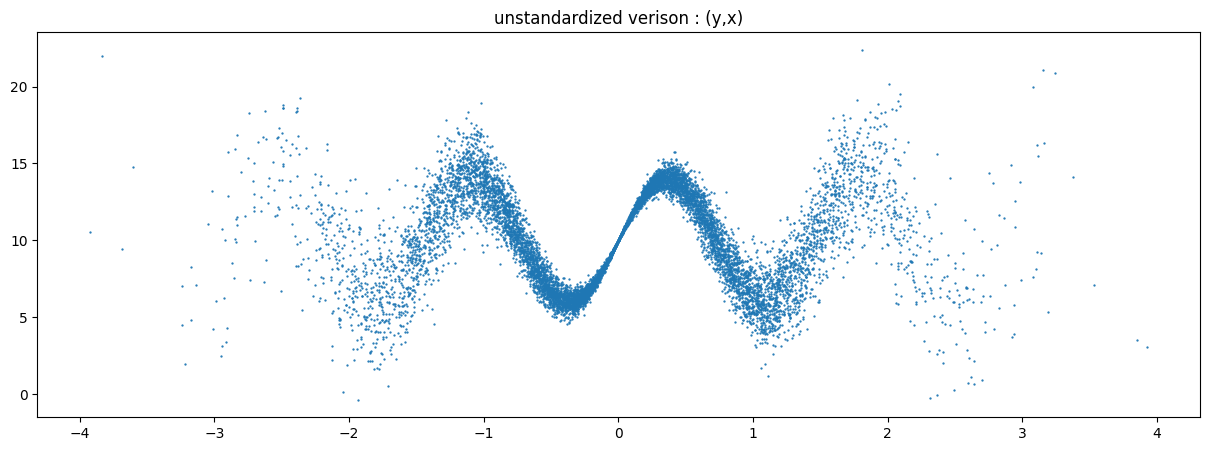

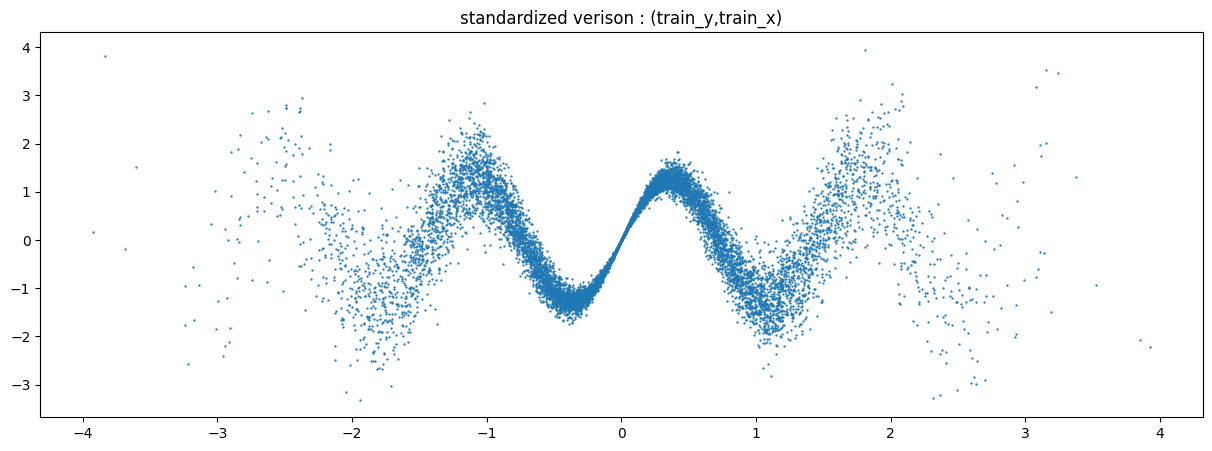

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.scatter(x, y, s=0.4)
plt.title('unstandardized verison : (y,x)')
plt.show()

plt.figure(figsize=(15,5))
plt.scatter(train_x, train_y, s=0.4)
plt.title('standardized verison : (train_y,train_x)')
plt.show()

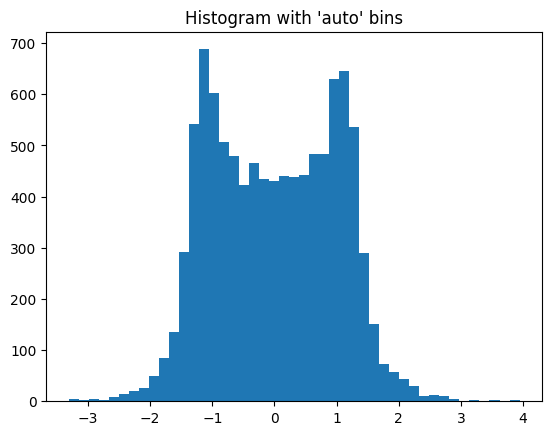

In [23]:
import pandas as pd

import torch
from torch import nn
import os
import matplotlib.pyplot as plt

#os.environ['KMP_DUPLICATE_LIB_OK']='True'

# data = pd.read_csv('/content/02_Linear_Regression_Model_Data.csv')

hist, bin_edges, _ = plt.hist(train_y, bins='auto')  # arguments are passed to np.histogram
class_digits = np.digitize(train_y, bin_edges) # Get the class of each point using histogram bins

no_of_classes = bin_edges.shape[0]+1
one_hots = np.zeros((train_y.size, no_of_classes))
one_hots[np.arange(train_y.size), class_digits] = 1

plt.title("Histogram with 'auto' bins")
plt.show()

# Avoid copy data, just refer
train_x_tr = torch.from_numpy(train_x.reshape([-1,1])).float()#torch.from_numpy(data['x'].values[:1000]).unsqueeze(dim=1).float()
train_y_scalar = torch.from_numpy(train_y.reshape([-1,1])).float()#torch.from_numpy(data['y'].values[:1000]).unsqueeze(dim=1).float()
train_y_tr = torch.from_numpy(one_hots.reshape([-1, no_of_classes])).float()#torch.from_numpy(data['y'].values[:1000]).unsqueeze(dim=1).float()

In [24]:
class QClassifier(torch.nn.Module):
    def __init__(self, in_size=1, no_of_classes=55):
        super(QClassifier,self).__init__()
        self.in_size = in_size
        self.out_size = no_of_classes

        hidden_layer = 64

        self.net = torch.nn.Sequential(
            torch.nn.Linear(self.in_size, hidden_layer),
            torch.nn.LeakyReLU(),

            torch.nn.Linear(hidden_layer, hidden_layer),
            # torch.nn.Dropout(p=0.9),
            torch.nn.LeakyReLU(),

            torch.nn.Linear(hidden_layer, self.out_size)
            )

    def forward(self,x):
        return self.net(x)



In [25]:
train_x_tr = train_x_tr.to(device)
train_y_tr = train_y_tr.to(device)

model = QClassifier(in_size=1, no_of_classes=no_of_classes).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [26]:
for step in range(3000):
    model.train()
    #yq1, yq2, yq3 = model(x)
    #loss = criterion(input=(yq1, yq2, yq3), target=y)
    logits = model(train_x_tr)
    loss = criterion(logits, train_y_tr)
    #print(yqs.shape, train_y_tr.shape)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step==0) or ((step+1) % 1000 == 0):
        """
        Show your intermediate results
        """
        print('epoch {} loss={:.4}'.format(step+1, loss.data.item()))
        pass

epoch 1 loss=3.869
epoch 1000 loss=2.035
epoch 2000 loss=1.949
epoch 3000 loss=1.921


In [27]:
bin_edges

array([-3.31173894, -3.15051361, -2.98928828, -2.82806296, -2.66683763,
       -2.50561231, -2.34438698, -2.18316165, -2.02193633, -1.860711  ,
       -1.69948568, -1.53826035, -1.37703502, -1.2158097 , -1.05458437,
       -0.89335904, -0.73213372, -0.57090839, -0.40968307, -0.24845774,
       -0.08723241,  0.07399291,  0.23521824,  0.39644357,  0.55766889,
        0.71889422,  0.88011954,  1.04134487,  1.2025702 ,  1.36379552,
        1.52502085,  1.68624617,  1.8474715 ,  2.00869683,  2.16992215,
        2.33114748,  2.49237281,  2.65359813,  2.81482346,  2.97604878,
        3.13727411,  3.29849944,  3.45972476,  3.62095009,  3.78217542,
        3.94340074])

In [28]:
no_of_classes

47

In [29]:
bin_edges

array([-3.31173894, -3.15051361, -2.98928828, -2.82806296, -2.66683763,
       -2.50561231, -2.34438698, -2.18316165, -2.02193633, -1.860711  ,
       -1.69948568, -1.53826035, -1.37703502, -1.2158097 , -1.05458437,
       -0.89335904, -0.73213372, -0.57090839, -0.40968307, -0.24845774,
       -0.08723241,  0.07399291,  0.23521824,  0.39644357,  0.55766889,
        0.71889422,  0.88011954,  1.04134487,  1.2025702 ,  1.36379552,
        1.52502085,  1.68624617,  1.8474715 ,  2.00869683,  2.16992215,
        2.33114748,  2.49237281,  2.65359813,  2.81482346,  2.97604878,
        3.13727411,  3.29849944,  3.45972476,  3.62095009,  3.78217542,
        3.94340074])

In [30]:
min_val, max_val = bin_edges.min()-0.3, bin_edges.max()+0.3
width = 0.01

x_pred = np.arange(-4,4,width)

intervals = np.array(list(zip([min_val, *bin_edges], [*bin_edges, max_val])))
intervals.shape
bbox_x = x_pred-(width/2)
bbox_y = intervals[:,0]
bbox_w = np.array([width]*intervals.shape[0])
bbox_h = intervals[:,1] - intervals[:,0]

In [31]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [32]:
sorted_indices.shape[0]

NameError: name 'sorted_indices' is not defined

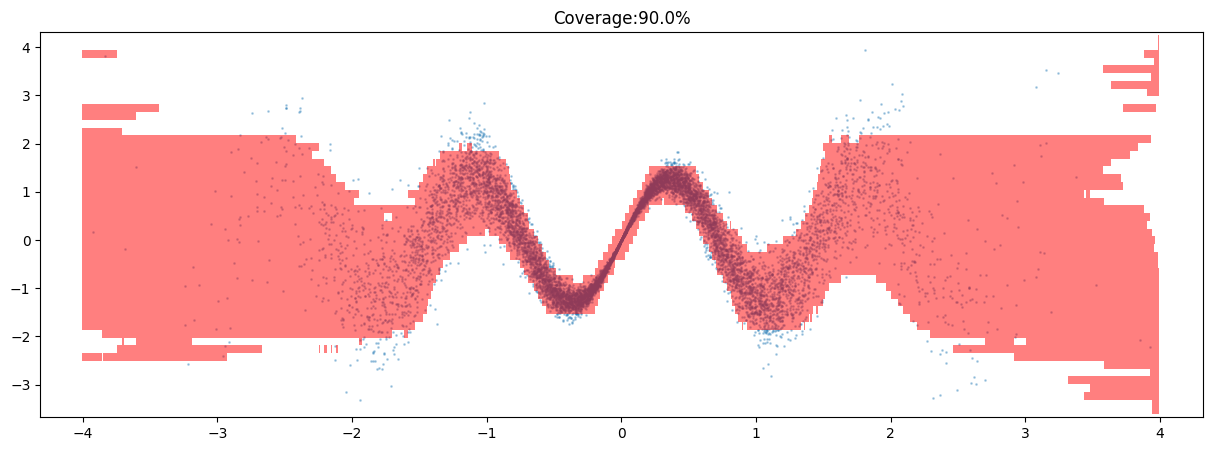

In [118]:
x_pred = torch.from_numpy(np.arange(-4,4,width).reshape([-1,1])).float()#torch.from_numpy(data['x'].values[:1000]).unsqueeze(dim=1).float()
model.eval()
y_pred = model(x_pred.to(device))

probs = y_pred.softmax(dim=1)

sorted_pdf, sorted_indices = probs.detach().cpu().sort(dim=1, descending=True)
sorted_cdf = sorted_pdf.cumsum(dim=1)
tau = 0.90
first_nth_indices = ((sorted_cdf >= tau)*1).argmax(dim=1)
# first_nth_indices

pred_boxes = []
for i in range(sorted_indices.shape[0]):
    # print(sorted_indices[i][:first_nth_indices[i]+1])
    prediction_set = sorted_indices[i, :first_nth_indices[i]+1]
    for j in prediction_set:
        xy = (bbox_x[i], bbox_y[j])
        height = bbox_h[j]
        # width = bbox_w[i]
        pred_boxes.append(Rectangle(xy, width, height))


# plt.figure(figsize=(15,5))
fig, ax = plt.subplots(figsize=(15,5))
# Create patch collection with specified colour/alpha
pc = PatchCollection(pred_boxes, facecolor='r', alpha=0.5,
                    edgecolor='none')

# Add collection to axes
ax.set_title(f"Coverage:{tau*100}%")
ax.scatter(train_x, train_y, s=1, alpha=0.3)
ax.add_collection(pc)

In [116]:
x_pred

tensor([[-4.0000e+00],
        [-3.9900e+00],
        [-3.9800e+00],
        [-3.9700e+00],
        [-3.9600e+00],
        [-3.9500e+00],
        [-3.9400e+00],
        [-3.9300e+00],
        [-3.9200e+00],
        [-3.9100e+00],
        [-3.9000e+00],
        [-3.8900e+00],
        [-3.8800e+00],
        [-3.8700e+00],
        [-3.8600e+00],
        [-3.8500e+00],
        [-3.8400e+00],
        [-3.8300e+00],
        [-3.8200e+00],
        [-3.8100e+00],
        [-3.8000e+00],
        [-3.7900e+00],
        [-3.7800e+00],
        [-3.7700e+00],
        [-3.7600e+00],
        [-3.7500e+00],
        [-3.7400e+00],
        [-3.7300e+00],
        [-3.7200e+00],
        [-3.7100e+00],
        [-3.7000e+00],
        [-3.6900e+00],
        [-3.6800e+00],
        [-3.6700e+00],
        [-3.6600e+00],
        [-3.6500e+00],
        [-3.6400e+00],
        [-3.6300e+00],
        [-3.6200e+00],
        [-3.6100e+00],
        [-3.6000e+00],
        [-3.5900e+00],
        [-3.5800e+00],
        [-3

<BarContainer object of 47 artists>

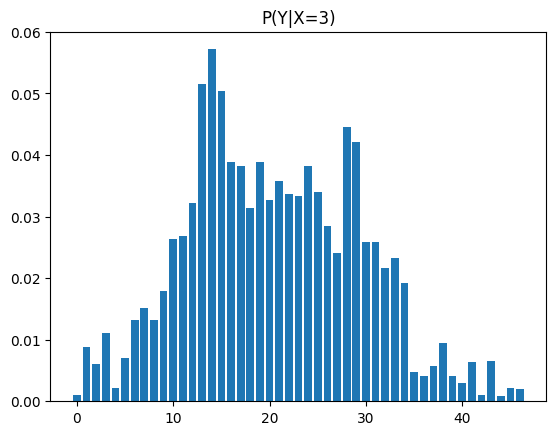

In [117]:
# Prediction for x=0
zero_preds = model(torch.tensor([3]).reshape([-1,1]).float().to(device)).softmax(dim=1)
# zero_preds.sort(descending=True, dim=1)
zero_preds_np = zero_preds.detach().cpu().numpy()
plt.title("P(Y|X=3)")
plt.bar(np.arange(zero_preds_np.shape[1]), height=zero_preds_np.reshape([-1]))

In [35]:
np.digitize(0, bin_edges) # Get the class of each point using histogram bins

22

In [36]:
# 3-headed output
# modification to MyModel
#    return output1, output2, output3 -> return self.net(x)  # torch.nn.Linear(30,3)
class QRegressor(torch.nn.Module):
    def __init__(self, in_size=1, out_size=1):
        super(QRegressor,self).__init__()
        self.in_size = in_size
        self.out_size = out_size

        hidden_layer = 64

        self.net = torch.nn.Sequential(
            torch.nn.Linear(self.in_size, hidden_layer),
            torch.nn.LeakyReLU(),

            torch.nn.Linear(hidden_layer, hidden_layer),
            torch.nn.LeakyReLU(),

            torch.nn.Linear(hidden_layer, 2*self.out_size)
            )

    def forward(self,x):
        x = self.net(x)
        b_size = x.shape[0]
        return x.reshape(b_size,2,self.out_size)



In [37]:
def PinballLoss(prediction, target,q_low,q_high):
    '''
    For each sample, the loss is:
    (q_low)*(y-f(x)) if y < f(x)
    (q_high)*(y-f(x)) if y >= f(x)
    where q_low and q_high are quantiles of interest
    '''    
    
    dim_num = prediction.shape[2]
    
    losses = []
    for i in range(dim_num):
        pred = prediction[:,:,i]
        t = target[:,i:i+1]
        e_low =  t - pred[:,0:1]  # !!! if input[:,0]  -> shape = (1000,)
        e_high = t - pred[:,1:2] 
        eq_low = torch.max(q_low*e_low, (q_low-1)*e_low)
        eq_high = torch.max(q_high*e_high, (q_high-1)*e_high)
        loss = (eq_low + eq_high).mean()
        losses.append(loss)

    return torch.stack(losses).mean()

In [38]:
train_y_tr.shape

torch.Size([10000, 47])

In [39]:
train_x_tr = train_x_tr.to(device)
train_y_scalar = train_y_scalar.to(device)

model = QRegressor().to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [40]:
for step in range(3000):
    #yq1, yq2, yq3 = model(x)
    #loss = criterion(input=(yq1, yq2, yq3), target=y)
    yqs = model(train_x_tr)

    loss = PinballLoss(prediction=yqs, target =train_y_scalar,q_low=0.05,q_high=0.95)
    #print(yqs.shape, train_y_tr.shape)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step+1) % 1000 == 0:
        """
        Show your intermediate results
        """
        print('epoch {} loss={:.4}'.format(step+1, loss.data.item()))
        pass
    



epoch 1000 loss=0.0772
epoch 2000 loss=0.07239
epoch 3000 loss=0.07175


In [41]:
train_y_scalar.shape

torch.Size([10000, 1])

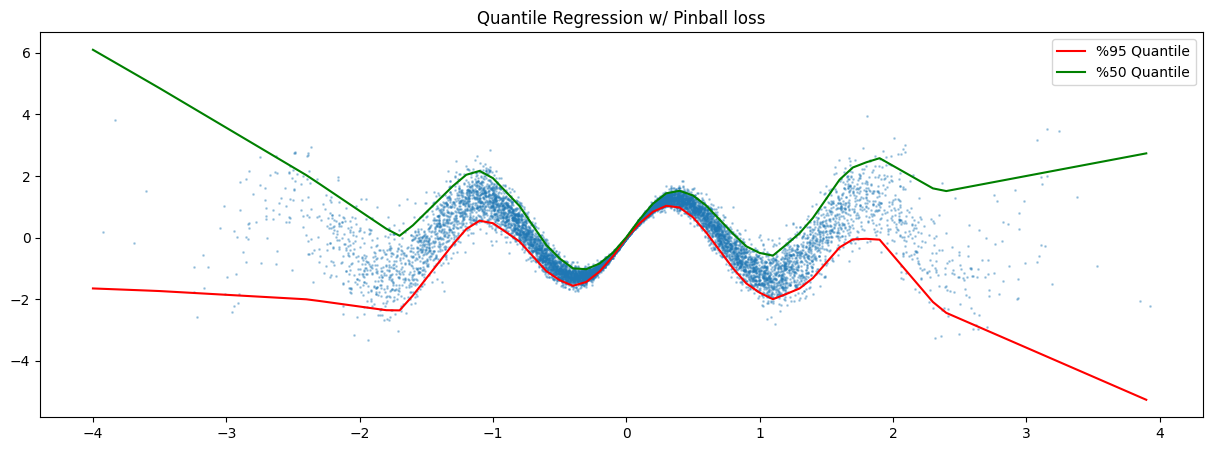

In [42]:
x_pred = torch.from_numpy(np.arange(-4,4,0.1).reshape([-1,1])).float()#torch.from_numpy(data['x'].values[:1000]).unsqueeze(dim=1).float()
y_pred = model(x_pred.to(device))

plt.figure(figsize=(15,5))

plt.title("Quantile Regression w/ Pinball loss")
plt.scatter(train_x, train_y, s=1, alpha=0.3)

plt.plot(x_pred.detach().cpu().numpy(), y_pred.detach().cpu().numpy()[:,0], c='r', label="%95 Quantile")
plt.plot(x_pred.detach().cpu().numpy(), y_pred.detach().cpu().numpy()[:,1], c='g', label="%50 Quantile")
# plt.plot(x_pred.detach().cpu().numpy(), y_pred.detach().cpu().numpy()[:,2], c='y', label="%05 Quantile")
plt.legend()

plt.show()

In [43]:
y_pred.shape

torch.Size([80, 2, 1])

In [62]:
# def conformalized_quantile_regression(model, x_calib,y_calib, tau):

alpha = 0.1

# Get the prediction
y_pred = model(train_x_tr.to(device))

# Calculate the residuals

res_lows = y_pred[:,0:1,0] - train_y_scalar
res_high = train_y_scalar - y_pred[:,1:2,0] 

residuals = torch.max(torch.stack([res_lows, res_high],dim=1).squeeze(),dim=1)[0].detach().cpu().numpy()


adapted_alpha = (1-alpha) * (1 + 1/len(train_x_tr))

# # Calculate the quantile residuals
quantile_residuals = np.quantile(residuals, adapted_alpha, axis=0)



In [63]:
residuals

array([-0.09697253, -0.05172092,  0.20099558, ..., -0.35897803,
       -0.31105864, -0.15499222], dtype=float32)

In [64]:
sum(res_lows > 0)

tensor([526], device='cuda:0')

In [65]:
res_high

tensor([[-0.6049],
        [-0.1144],
        [-1.1339],
        ...,
        [-0.6435],
        [-0.3111],
        [-0.1550]], device='cuda:0', grad_fn=<SubBackward0>)

In [66]:
quantile_residuals

0.0024304377025365894

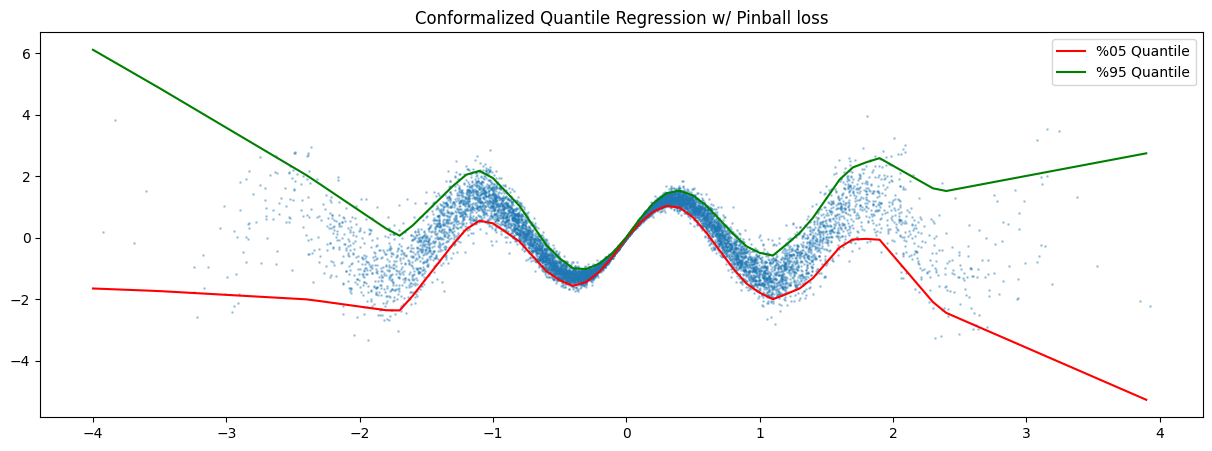

In [67]:
x_pred = torch.from_numpy(np.arange(-4,4,0.1).reshape([-1,1])).float()#torch.from_numpy(data['x'].values[:1000]).unsqueeze(dim=1).float()
y_pred = model(x_pred.to(device))

plt.figure(figsize=(15,5))

plt.title("Conformalized Quantile Regression w/ Pinball loss")
plt.scatter(train_x, train_y, s=1, alpha=0.3)

plt.plot(x_pred.detach().cpu().numpy(), y_pred.detach().cpu().numpy()[:,0] - quantile_residuals, c='r', label="%05 Quantile")
plt.plot(x_pred.detach().cpu().numpy(), y_pred.detach().cpu().numpy()[:,1] + quantile_residuals, c='g', label="%95 Quantile")
plt.legend()

plt.show()

In [77]:
y_pred.shape

torch.Size([10000, 2, 1])

In [78]:
# Assuming y_pred is of shape (N, 2) and train_y_scalar is of shape (N,)

y_pred = model(train_x_tr.to(device))


pred_lower = y_pred[:, 0]
pred_upper = y_pred[:, 1]
y = train_y_scalar

# Create a boolean mask where the condition is True
covered_mask = (pred_lower <= y) & (y <= pred_upper)

# Sum up the True values to get the count
covered = covered_mask.sum().item()

In [79]:
covered / train_x_tr.shape[0]

0.8962

In [84]:
# Assuming y_pred has shape (N, boundaries_shape, 1)
# and train_y_scalar has shape (N, D), where D is the dimensionality of y

import torch

# Get the batch size and boundaries_shape
N = y_pred.shape[0]
boundaries_shape = y_pred.shape[1]

# Calculate the dimensionality of y
D = train_y_scalar.shape[1] if train_y_scalar.dim() > 1 else 1

# Reshape y_pred to (N, D, 2)
y_pred = y_pred.view(N, D, 2)

# Remove the last singleton dimension if present
if y_pred.shape[-1] == 1:
    y_pred = y_pred.squeeze(-1)  # Now y_pred has shape (N, D, 2)

# Extract lower and upper bounds
pred_lower = y_pred[:, :, 0]  # Shape: (N, D)
pred_upper = y_pred[:, :, 1]  # Shape: (N, D)

# Ensure train_y_scalar is two-dimensional
y = train_y_scalar if train_y_scalar.dim() > 1 else train_y_scalar.unsqueeze(1)  # Shape: (N, D)

# Create a boolean mask where each element is True if y is within the bounds
covered_mask = (pred_lower <= y) & (y <= pred_upper)  # Shape: (N, D)

# Check if all dimensions are covered for each sample
sample_covered = covered_mask.all(dim=1)  # Shape: (N,)

# Sum up the True values to get the total count
covered = sample_covered.sum().item() 
coveage = covered / N

In [ ]:
import torch

# Assuming y_pred has shape (N, boundaries_shape, 1)
# and train_y_scalar has shape (N, D), where D is the dimensionality of y

# Get the batch size and boundaries_shape
N = y_pred.shape[0]
boundaries_shape = y_pred.shape[1]

# Calculate the dimensionality of y
D = train_y_scalar.shape[1] if train_y_scalar.dim() > 1 else 1

# Reshape y_pred to (N, D, 2)
y_pred = y_pred.view(N, D, 2)

# Remove the last singleton dimension if present
if y_pred.shape[-1] == 1:
    y_pred = y_pred.squeeze(-1)  # Now y_pred has shape (N, D, 2)

# Extract lower and upper bounds
pred_lower = y_pred[:, :, 0]  # Shape: (N, D)
pred_upper = y_pred[:, :, 1]  # Shape: (N, D)

# **Check for band crossing**
# Create a boolean mask where the lower bound is greater than the upper bound
# band_crossing_mask = pred_lower > pred_upper  # Shape: (N, D)

# Count the number of band crossings
# num_band_crossings = band_crossing_mask.sum().item()

# Handle band crossings
# if num_band_crossings > 0:
#     print(f"Warning: {num_band_crossings} band crossings detected.")

#     # Swap the bounds where band crossing occurs
#     pred_lower_corrected = torch.where(band_crossing_mask, pred_upper, pred_lower)
#     pred_upper_corrected = torch.where(band_crossing_mask, pred_lower, pred_upper)

#     # Use the corrected bounds
#     pred_lower = pred_lower_corrected
#     pred_upper = pred_upper_corrected

# Ensure train_y_scalar is two-dimensional
y = train_y_scalar if train_y_scalar.dim() > 1 else train_y_scalar.unsqueeze(1)  # Shape: (N, D)

# Create a boolean mask where each element is True if y is within the bounds
covered_mask = (pred_lower <= y) & (y <= pred_upper)  # Shape: (N, D)

# Check if all dimensions are covered for each sample
sample_covered = covered_mask.all(dim=1)  # Shape: (N,)

# Sum up the True values to get the total count
covered = sample_covered.sum().item()

print(f"Total samples covered: {covered} out of {N}")

# **Calculate PINAW**

# Compute the width of the prediction intervals
interval_width = pred_upper - pred_lower  # Shape: (N, D)

# Compute the range of the actual target values for normalization
# For multi-dimensional y, we compute the range for each dimension separately
y_min = y.min(dim=0)[0]  # Shape: (D,)
y_max = y.max(dim=0)[0]  # Shape: (D,)
R = y_max - y_min  # Shape: (D,)

# Avoid division by zero in case of zero range
R = torch.where(R == 0, torch.tensor(1e-8, device=R.device), R)

# Normalize the interval widths
normalized_interval_width = interval_width / R  # Shape: (N, D)

# Compute the average normalized width for each dimension
PINAW_per_dimension = normalized_interval_width.mean(dim=0)  # Shape: (D,)

# Compute the overall PINAW by averaging over all dimensions
PINAW = PINAW_per_dimension.mean().item()

print(f"PINAW score: {PINAW}")